Data Processing First Step: Changing audio file to Waveform

Loading Timit Training Dataset using DeepLake

In [ ]:
#!pip install "deeplake<4" RUN THIS THE FIRST TIME
import deeplake
Training_Data_Set = deeplake.load("hub://activeloop/timit-train")

\

Opening dataset in read-only mode as you don't have write permissions.


/

This dataset can be visualized in Jupyter Notebook by ds.visualize() or at https://app.activeloop.ai/activeloop/timit-train



\

hub://activeloop/timit-train loaded successfully.



Citation

In [ ]:
'''
CITATION
@inproceedings,
  title = {TIMIT Acoustic-Phonetic Continuous Speech Corpus},
  author = {John S. Garofolo, Lori F. Lamel, William M. Fisher, Jonathan G. Fiscus, David S. Pallett, Nancy L. Dahlgren, Victor Zue},
  booktitle = {Linguistic Data Consortium, },
  year = {1993}
}
'''

Testing the dataset

[[ 5.]
 [ 5.]
 [ 5.]
 ...
 [-1.]
 [ 5.]
 [ 4.]]
['Publicity and notoriety go hand in hand.']


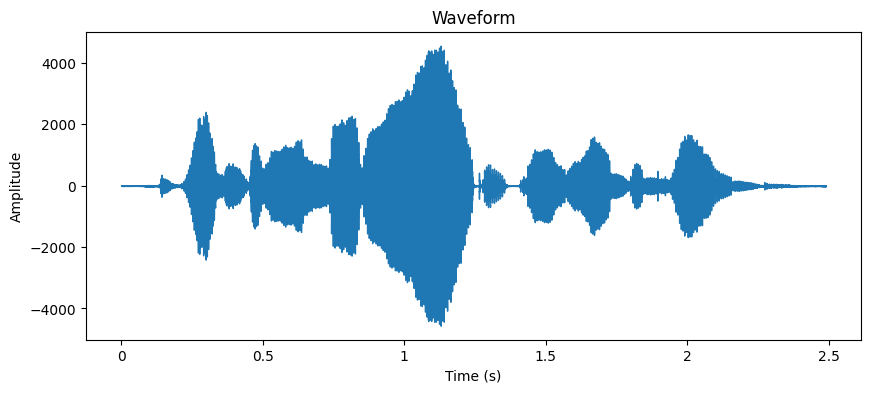

In [ ]:
import librosa
import matplotlib.pyplot as plt
sample = Training_Data_Set[0]  #access the first sample

#access the audio waveform from the 'audios' tensor
def process_timit_sample(sample):
    audio = sample['audios'].numpy() #extract the audio waveform as a NumPy array
    texts = sample['texts'].numpy() #extract the corresponding text
    print(audio)
    print(texts)
    sr = 16000 #TIMIT dataset has a 16kHz sample rate
    if len(audio.shape) > 1:
            audio = audio.flatten()
    #plot the waveform
    plt.figure(figsize=(10, 4))
    librosa.display.waveshow(audio, sr=sr)
    plt.title('Waveform')
    plt.xlabel('Time (s)')
    plt.ylabel('Amplitude')
    plt.show()

process_timit_sample(sample)
